In [37]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='password',
    database='Ecommerse'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Hp/Desktop/ECommerse'


def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [38]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "password",
                             database ="Ecommerse")
cur = db.cursor()

In [39]:
#  list all unique cities where customers are located.

query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [40]:
# Count the no of orders placed in 2017

query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data [0] [0]



('total orders placed in 2017 are', 225505)

In [41]:
# calculate the percentage of orders that were paid in installments

query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

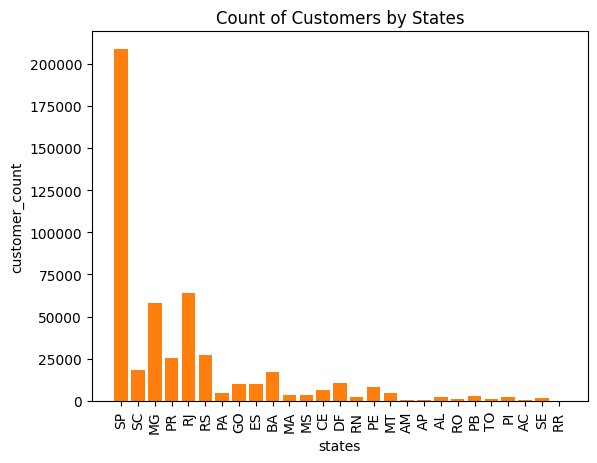

In [42]:
# count the no of customers from each state
query = """ select customer_state , count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])

plt.bar(df["state"], df["customer_count" ])

plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")

plt.show()

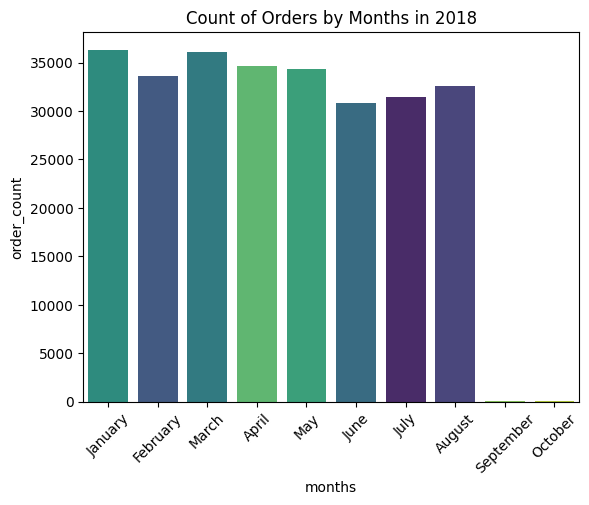

In [43]:
# calculate the number of orders per month in 2018

query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df =pd.DataFrame(data, columns = ["months", "order_count"])
o =["January","February","March","April","May","June","July","August","September","October"]

sns.barplot(x = df["months"],y = df["order_count"], data = df ,order = o ,hue = df["months"],palette ="viridis")
plt.xticks(rotation =45)

plt.title("Count of Orders by Months in 2018")

plt.show()

In [44]:
# Find the average number of products per order, grouped by customer city.

query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = [ "customer city", "average products/order"])
df

,customer city,average products/order
0,treze tilias,25.45
1,indaial,22.31
2,sao jose dos campos,22.77
3,sao paulo,23.12
4,porto alegre,23.50
...,...,...
4105,guairaca,40.00
4106,sambaiba,20.00
4107,japaratuba,20.00
4108,tuiuti,20.00


In [45]:
#calculate the percentage of total revenue contributed by each product category.
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host ="localhost",
                             username ="root",
                             password ="password",
                             database ="Ecommerse")

cur = db.cursor()

query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc """

cur.execute(query)

df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,treze tilias,25.45
1,indaial,22.31
2,sao jose dos campos,22.77
3,sao paulo,23.12
4,porto alegre,23.50


In [46]:
# identify the correlation between product price and  the number of times a product has been purchased .
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host ="localhost",
                              username ="root",
                              password ="password",
                              database ="Ecommerse")
cur = db.cursor()

query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
df

,Category,order_count,price
0,HEALTH BEAUTY,193400,130.16
1,sport leisure,172820,114.34
2,Cool Stuff,75920,167.36
3,computer accessories,156540,116.51
4,Watches present,119820,201.14
...,...,...,...
69,Kitchen portable and food coach,300,264.57
70,House Comfort 2,600,25.34
71,CITTE AND UPHACK FURNITURE,760,114.95
72,insurance and services,40,141.64


In [48]:
arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][-1])

the correlation between price and number of times a product has been purchased is -0.10631514167157564


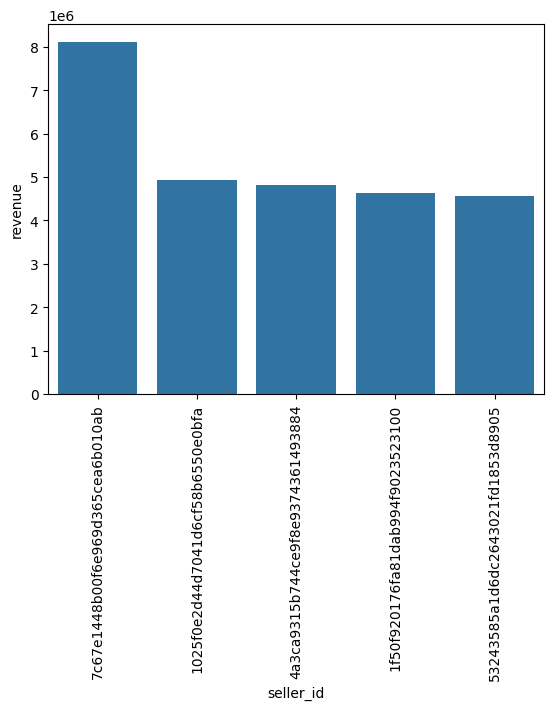

In [53]:
# calculate the total revenue generated by each seller,and rank this by revenue.

query = """ select *,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id", y ="revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [55]:
#calculate the moving average of order values for each customer over their order history.
query = """ select customer_id, order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)


,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
5,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
6,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
7,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
8,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
9,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


In [56]:
# calculate the cumulative sales per month for each year.
query = """ select years, months,payment,sum(payment)
over(order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,5044.80,5.044800e+03
1,2016,10,1181809.60,1.186854e+06
2,2016,12,392.40,1.187247e+06
3,2017,1,2769760.80,3.957008e+06
4,2017,2,5838160.19,9.795168e+06
5,2017,3,8997271.99,1.879244e+07
6,2017,4,8355760.59,2.714820e+07
7,2017,5,11858376.40,3.900658e+07
8,2017,6,10225527.61,4.923210e+07
9,2017,7,11847658.39,6.107976e+07


In [60]:
# calculate the year -over- year growth rate of total sales.

query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,((payment - lag(payment,1) over(order by years))/
lag(payment,1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","yoy % growth"])
df
 

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


NameError: name 'pt' is not defined

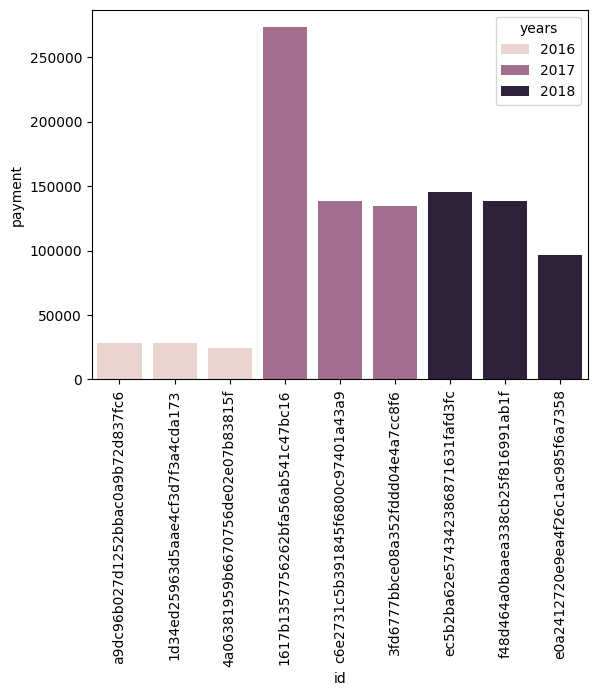

In [76]:
#identify the top 3 customers who spent the most money in each year.
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mysql.connector

db = mysql.connector.connect( host ="localhost",
                             username ="root",
                             password ="password",
                             database ="Ecommerse")
cur = db.cursor()
query = """select years, customer_id, payment, d_rank
 from
 (select year(orders.order_purchase_timestamp)years,
 orders.customer_id,
 sum(payments.payment_value) payment,
 dense_rank() over(partition by year(orders.order_purchase_timestamp)
 order by sum(payments.payment_value) desc) d_rank
 from orders join payments
 on payments.order_id = orders.order_id
 group by year(orders.order_purchase_timestamp),
 orders.customer_id) as a
 where d_rank <= 3 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
pt.show()